In [98]:
def data():
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import StandardScaler
    from tensorflow.keras.preprocessing import timeseries_dataset_from_array
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout
    import tensorflow as tf
    from hyperas.distributions import choice, uniform
    from hyperas import optim

    df = pd.read_csv("differenced_data.csv")
    df.drop(["Date"], axis=1, inplace=True)

    train_df = df[0:int(len(df)*.7)]
    val_df = df[int(len(df)*.7):int(len(df)*.9)]
    # test_df = df[int(len(df)*.9):]

    # train_len = int(len(train_df)*.9)

    # train_df = train_df[:train_len]
    # val_df = train_df[train_len:]

    scaler = StandardScaler()
    scaler.fit(train_df)

    train_scaled = scaler.transform(train_df)
    val_scaled = scaler.transform(val_df)
    # test_scaled = scaler.transform(test_df)

    input_width = 6
    label_width = 6
    shift = 1
    label_columns = None

    column_indeces = {name: i for i, name in enumerate(train_df.columns)}
    if label_columns is not None:
        label_column_indeces = {name: i for i, name in enumerate(label_columns)}

    window_size = input_width + shift

    input_slice = slice(0, input_width)
    input_indeces = np.arange(window_size)[input_slice]

    label_start = window_size - label_width
    label_slice = slice(label_start, None)
    label_indeces =  np.arange(window_size)[label_slice]

    def split_window(features):
        inputs = features[:, input_slice, :]
        labels = features[:, label_slice, :]
        if label_columns:
            labels = tf.stack([labels[:, :, column_indeces[name]] for name in label_columns], axis=1)

        inputs.set_shape([None, input_width, None])
        labels.set_shape([None, label_width, None])

        return inputs, labels

    def make_dataset(data):
        data = np.array(data, dtype=np.float64)
        dset = timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        dset = dset.map(split_window)
        return dset

    model_train = make_dataset(train_scaled)
    model_val = make_dataset(val_scaled)

    # # X_train = np.array(list(model_train.as_numpy_iterator()))[:,0]
    # # X_train  = np.array(list(model_train.as_numpy_iterator()))[:,0].flatten()
    # X_train = np.array(list(model_train.unbatch().as_numpy_iterator()))[:,0]
    # # #594 batches with each batch containing an array of (32,6,12)

    # # y_train = np.array(list(model_train.as_numpy_iterator()))[:,1]
    # # y_train  = np.array(list(model_train.as_numpy_iterator()))[:,1].flatten()
    # y_train = np.array(list(model_train.unbatch().as_numpy_iterator()))[:,1]

    # # X_val = np.array(list(model_val.as_numpy_iterator()))[:,0]
    # # X_val = np.array(list(model_val.as_numpy_iterator()))[:,0].flatten()
    # X_val = np.array(list(model_val.unbatch().as_numpy_iterator()))[:,0]

    # # y_val = np.array(list(model_val.as_numpy_iterator()))[:,1]
    # # y_val = np.array(list(model_val.as_numpy_iterator()))[:,1].flatten()
    # y_val = np.array(list(model_val.unbatch().as_numpy_iterator()))[:,1]

    train_data = np.array(train_scaled)
    val_data = np.array(val_scaled)

    # train_len = int(len(train_data)*.9)

    # train_data = train_data[:train_len]
    # val_data = train_data[train_len:]


    # end_index = train_data[:train_len]

    # print(len(train_data))

    train_data = timeseries_dataset_from_array(
                                            data = train_data,
                                            targets=None, 
                                            sequence_length=7, 
                                            shuffle=True, 
                                            batch_size=32)

    val_data = timeseries_dataset_from_array(
                                            data = val_data,
                                            targets = None,
                                            sequence_length = 7,
                                            shuffle = True,
                                            batch_size = 32)



    # dataset.inputs.set_shape(None, 6, None)

    train_dataset = train_data.map(split_window)
    val_dataset = val_data.map(split_window)

    return train_dataset, val_dataset

In [99]:
# def create_model(train_dataset, val_dataset):

#     from sklearn.model_selection import train_test_split
#     from sklearn.metrics import mean_squared_error
#     from sklearn.preprocessing import StandardScaler

#     from tensorflow.keras.models import Sequential
#     from tensorflow.keras.layers import Dense
#     from tensorflow.keras.layers import LSTM
#     import tensorflow as tf

#     model = Sequential()
#     model.add(LSTM(16),
#             return_sequences=True 
#            # ,input_shape=(X_train.shape[1], X_train.shape[2]))
#         #    , batch_input_shape=(None, X_train.shape[1], X_train.shape[2])
#             )

#     model.add(Dense(16, activation = 'relu'))
#     model.add(Dense(12))
#     model.compile(loss="mae", 
#                 optimizer="adam", 
#                 metrics=["mae", "mse"]
#                 )
#     e_stop =  tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")

#     # train_len = int(len(train_dataset)*.9)

#     # result = model.fit(train_dataset[:train_len], epochs=25, batch_size=60, validation_data=train_dataset[:train_len], verbose=2, callbacks = [e_stop], shuffle=False)

#     result = model.fit(train_dataset, epochs=25, batch_size=60, validation_data=val_dataset, verbose=2, callbacks = [e_stop], shuffle=False)

#     # print(result.history)

#     validation_loss = np.amin(result.history['val_loss'])
#     plt.plot(result.history["loss"], label="train")
#     plt.plot(result.history["val_loss"], label="val")
#     plt.legend(loc="upper right")
#     plt.title('Training Loss vs. Validation Loss')
#     plt.show()
#     print('Best Validation loss of epoch:', validation_loss)
#     return {'loss': validation_loss, 'status': STATUS_OK, 'model':model}

In [100]:
def create_model(train_dataset, val_dataset):

    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import StandardScaler

    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout
    from tensorflow.keras.layers import LSTM
    import tensorflow as tf
    import matplotlib.pyplot as plt

    model = Sequential()
    model.add(LSTM({{choice([8,16,32])}},
            return_sequences=True 
           # ,input_shape=(X_train.shape[1], X_train.shape[2]))
        #    , batch_input_shape=(None, X_train.shape[1], X_train.shape[2])
            ))

    model.add(Dense({{choice([10, 12])}}, activation='relu'))

    model.add(Dense(12))

    model.add(Activation('relu'))

    # model.add(Dropout({{uniform(0, 1)}}))

    model.compile(loss="mae", 
                optimizer="adam", 
                metrics=["mae", "mse"]
                )
    e_stop =  tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")

    # train_len = int(len(train_dataset)*.9)

    # result = model.fit(train_dataset[:train_len], epochs=25, batch_size=60, validation_data=train_dataset[:train_len], verbose=2, callbacks = [e_stop], shuffle=False)

    result = model.fit(train_dataset, validation_data=val_dataset, epochs=25, batch_size=60,callbacks = [e_stop], verbose=2, shuffle=False)

    # print(result.history)

    validation_loss = np.amin(result.history['val_loss'])
    print('Best Validation loss of epoch:', validation_loss)
    plt.plot(result.history["loss"], label="train")
    plt.plot(result.history["val_loss"], label="val")
    plt.legend(loc="upper right")
    plt.title('Training Loss vs. Validation Loss')
    plt.show()
    return {'loss': validation_loss, 'status': STATUS_OK, 'model':model}
    

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from tensorflow.keras.preprocessing import timeseries_dataset_from_array
except:
    pass

try:
    from tensorflow.keras.models import Sequential
except:
    pass

try:
    from tensorflow.keras.layers import LSTM, Dense, Activation
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.metrics import mean_squared_error
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from tensorflow.keras.models import Sequential
except:
    pass

try:
    from tensorflow.keras.layers import Dense, LSTM, Activation
except:
    pass

try:
    from tensorflow.keras.layers import LSTM
except:
    pass

try:
    import tensorflow as tf

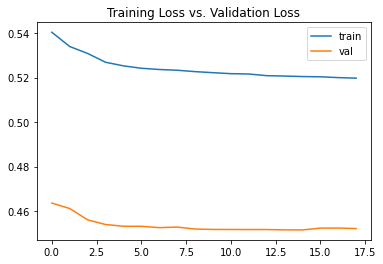

Epoch 1/25
  7%|▋         | 1/15 [01:16<17:47, 76.27s/trial, best loss: 0.45147690176963806]WARNING:tensorflow:Layer lstm_110 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

594/594 - 4s - loss: 0.5473 - mae: 0.5473 - mse: 0.9882 - val_loss: 0.4717 - val_mae: 0.4717 - val_mse: 0.7053

Epoch 2/25
594/594 - 4s - loss: 0.5401 - mae: 0.5401 - mse: 0.9707 - val_loss: 0.4677

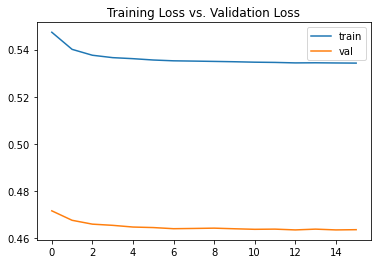

Epoch 1/25
 13%|█▎        | 2/15 [02:18<15:36, 72.03s/trial, best loss: 0.45147690176963806]WARNING:tensorflow:Layer lstm_111 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

594/594 - 4s - loss: 0.5514 - mae: 0.5514 - mse: 0.9976 - val_loss: 0.4800 - val_mae: 0.4800 - val_mse: 0.7248

Epoch 2/25
594/594 - 4s - loss: 0.5491 - mae: 0.5491 - mse: 0.9928 - val_loss: 0.4778

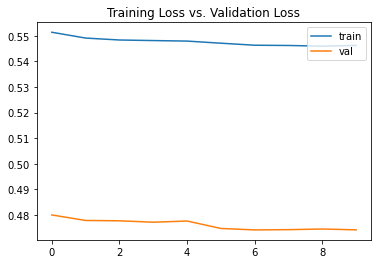

Epoch 1/25
 20%|██        | 3/15 [02:58<12:28, 62.35s/trial, best loss: 0.45147690176963806]WARNING:tensorflow:Layer lstm_112 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

594/594 - 4s - loss: 0.5447 - mae: 0.5447 - mse: 0.9823 - val_loss: 0.4664 - val_mae: 0.4664 - val_mse: 0.6934

Epoch 2/25
594/594 - 4s - loss: 0.5388 - mae: 0.5388 - mse: 0.9682 - val_loss: 0.4623

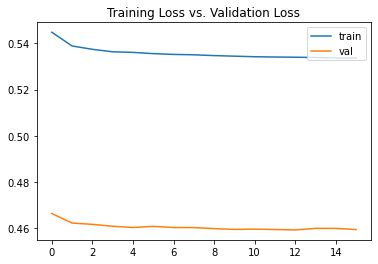

Epoch 1/25
 27%|██▋       | 4/15 [04:08<11:51, 64.69s/trial, best loss: 0.45147690176963806]WARNING:tensorflow:Layer lstm_113 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

594/594 - 6s - loss: 0.5510 - mae: 0.5510 - mse: 0.9953 - val_loss: 0.4776 - val_mae: 0.4776 - val_mse: 0.7191

Epoch 2/25
594/594 - 4s - loss: 0.5455 - mae: 0.5455 - mse: 0.9848 - val_loss: 0.4707

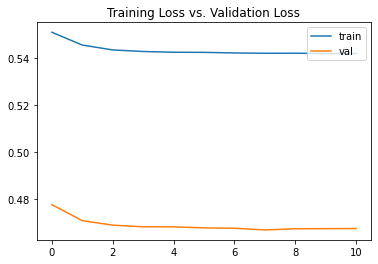

Epoch 1/25
 33%|███▎      | 5/15 [04:55<09:53, 59.33s/trial, best loss: 0.45147690176963806]WARNING:tensorflow:Layer lstm_114 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

594/594 - 4s - loss: 0.5381 - mae: 0.5381 - mse: 0.9672 - val_loss: 0.4589 - val_mae: 0.4589 - val_mse: 0.6768

Epoch 2/25
594/594 - 4s - loss: 0.5292 - mae: 0.5292 - mse: 0.9455 - val_loss: 0.4558

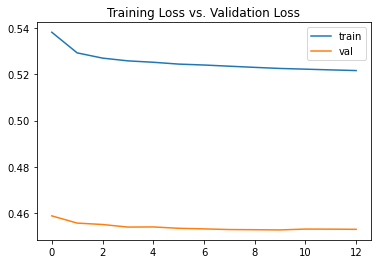

Epoch 1/25
 40%|████      | 6/15 [05:49<08:40, 57.78s/trial, best loss: 0.45147690176963806]WARNING:tensorflow:Layer lstm_115 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

594/594 - 4s - loss: 0.5478 - mae: 0.5478 - mse: 0.9898 - val_loss: 0.4699 - val_mae: 0.4699 - val_mse: 0.7018

Epoch 2/25
594/594 - 4s - loss: 0.5403 - mae: 0.5403 - mse: 0.9738 - val_loss: 0.4634

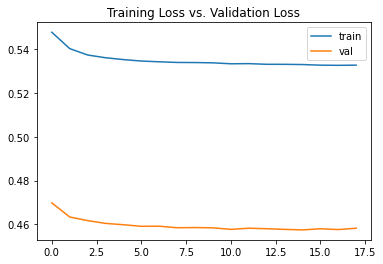

Epoch 1/25
 47%|████▋     | 7/15 [07:01<08:15, 61.97s/trial, best loss: 0.45147690176963806]WARNING:tensorflow:Layer lstm_116 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

594/594 - 4s - loss: 0.5507 - mae: 0.5507 - mse: 0.9959 - val_loss: 0.4799 - val_mae: 0.4799 - val_mse: 0.7239

Epoch 2/25
594/594 - 4s - loss: 0.5487 - mae: 0.5487 - mse: 0.9919 - val_loss: 0.4773

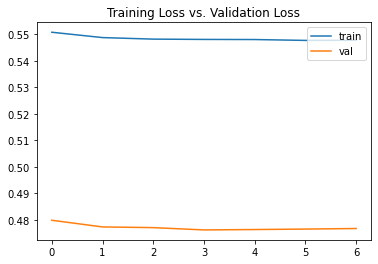

Epoch 1/25
 53%|█████▎    | 8/15 [07:31<06:06, 52.37s/trial, best loss: 0.45147690176963806]WARNING:tensorflow:Layer lstm_117 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

594/594 - 4s - loss: 0.5433 - mae: 0.5433 - mse: 0.9813 - val_loss: 0.4613 - val_mae: 0.4613 - val_mse: 0.6842

Epoch 2/25
594/594 - 3s - loss: 0.5341 - mae: 0.5341 - mse: 0.9606 - val_loss: 0.4593

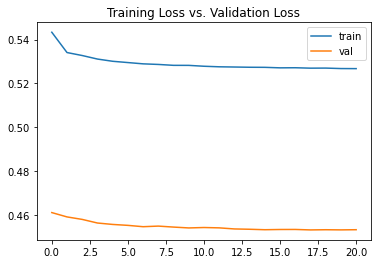

Epoch 1/25
 60%|██████    | 9/15 [08:59<06:18, 63.10s/trial, best loss: 0.45147690176963806]WARNING:tensorflow:Layer lstm_118 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

594/594 - 5s - loss: 0.5432 - mae: 0.5432 - mse: 0.9779 - val_loss: 0.4607 - val_mae: 0.4607 - val_mse: 0.6809

Epoch 2/25
594/594 - 4s - loss: 0.5321 - mae: 0.5321 - mse: 0.9527 - val_loss: 0.4576

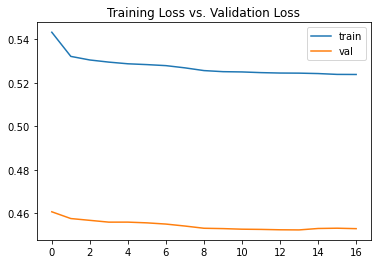

Epoch 1/25
 67%|██████▋   | 10/15 [10:17<05:38, 67.66s/trial, best loss: 0.45147690176963806]WARNING:tensorflow:Layer lstm_119 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

594/594 - 4s - loss: 0.5434 - mae: 0.5434 - mse: 0.9808 - val_loss: 0.4647 - val_mae: 0.4647 - val_mse: 0.6915

Epoch 2/25
594/594 - 4s - loss: 0.5379 - mae: 0.5379 - mse: 0.9700 - val_loss: 0.462

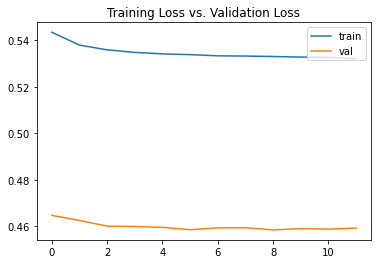

Epoch 1/25
 73%|███████▎  | 11/15 [11:12<04:15, 63.78s/trial, best loss: 0.45147690176963806]WARNING:tensorflow:Layer lstm_120 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

594/594 - 4s - loss: 0.5461 - mae: 0.5461 - mse: 0.9843 - val_loss: 0.4627 - val_mae: 0.4627 - val_mse: 0.6847

Epoch 2/25
594/594 - 4s - loss: 0.5275 - mae: 0.5275 - mse: 0.9408 - val_loss: 0.457

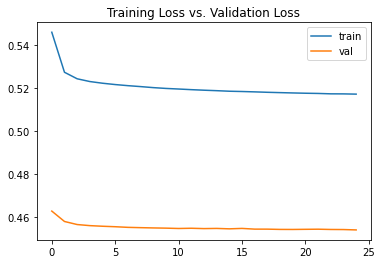

Epoch 1/25
 80%|████████  | 12/15 [13:03<03:53, 77.88s/trial, best loss: 0.45147690176963806]WARNING:tensorflow:Layer lstm_121 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

594/594 - 4s - loss: 0.5495 - mae: 0.5495 - mse: 0.9929 - val_loss: 0.4755 - val_mae: 0.4755 - val_mse: 0.7148

Epoch 2/25
594/594 - 4s - loss: 0.5459 - mae: 0.5459 - mse: 0.9853 - val_loss: 0.472

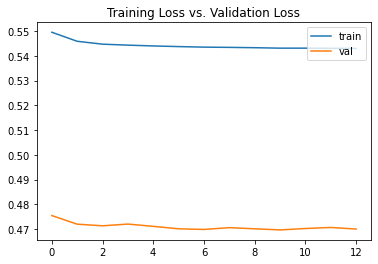

Epoch 1/25
 87%|████████▋ | 13/15 [13:56<02:21, 70.61s/trial, best loss: 0.45147690176963806]WARNING:tensorflow:Layer lstm_122 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

594/594 - 4s - loss: 0.5418 - mae: 0.5418 - mse: 0.9774 - val_loss: 0.4613 - val_mae: 0.4613 - val_mse: 0.6833

Epoch 2/25
594/594 - 4s - loss: 0.5309 - mae: 0.5309 - mse: 0.9538 - val_loss: 0.458

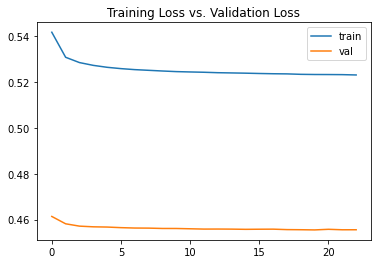

Epoch 1/25
 93%|█████████▎| 14/15 [15:34<01:18, 78.87s/trial, best loss: 0.45147690176963806]WARNING:tensorflow:Layer lstm_123 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

594/594 - 4s - loss: 0.5472 - mae: 0.5472 - mse: 0.9885 - val_loss: 0.4715 - val_mae: 0.4715 - val_mse: 0.7072

Epoch 2/25
594/594 - 4s - loss: 0.5393 - mae: 0.5393 - mse: 0.9704 - val_loss: 0.463

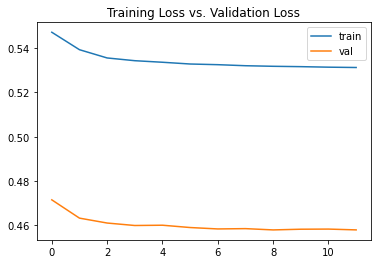

100%|██████████| 15/15 [16:30<00:00, 66.05s/trial, best loss: 0.45147690176963806]
Evaluation of best performing model:
170/170 [==============================] - 1s 6ms/step - loss: 0.4521 - mae: 0.4521 - mse: 0.6598
[0.45209160447120667, 0.4520915746688843, 0.6598216891288757]
Best Performing Model Hyper-Parameters:
{'Dense': 0, 'Dropout': 0.21280043312755825, 'LSTM': 2}


In [101]:
if __name__ == '__main__':

    from hyperas import optim
    from tensorflow.keras.models import Sequential
    from hyperopt import Trials, tpe
    from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout
    import tensorflow as tf

    best_run, best_model = optim.minimize(model=create_model,
                                            data=data,
                                            algo=tpe.suggest,
                                            max_evals=6,
                                            trials=Trials(),
                                            notebook_name = 'HyperParameter_Tuning_v3')
                                            
    train_dataset, val_dataset = data()
    print('Evaluation of best performing model:')
    print(best_model.evaluate(val_dataset))
    print("Best Performing Model Hyper-Parameters:")
    print(best_run)

In [92]:
model_45 = best_model

In [97]:
model_45.save('saved_models/loss_45')

INFO:tensorflow:Assets written to: saved_models/loss_45/assets
